# Stochastic Simulation Assignment 1

## Computing the Area of the Mandelbrot Set
_Authors: Sai Vinay Vardhan Daliparthi (15073815), Boyan Mihaylov (15067602), Nitai Nijholt (12709018)_

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy import stats
from scipy import constants

## Mandelbrot Simulation

The following functions compute the Mandelbrot set by iterating a regular rectangular grid of complex numbers through a recursive function.

In [2]:
# creating the coordinate plane
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
wsteps, hsteps = 1000, 1000
r1 = np.linspace(xmin, xmax, wsteps)
r2_imaginary = np.linspace(ymin*1j, ymax*1j, hsteps)
real_array, complex_array = np.meshgrid(r1,r2_imaginary)
complex_coordinate_plane = real_array + complex_array


In [3]:
def vectorized_mandlebrot(complex_coordinate_plane, max_iter, threshold):
    z = complex_coordinate_plane.copy()
    diverged_at = np.full(z.shape, max_iter)

    for n in range(max_iter):
        diverged = abs(z) > threshold
        diverged_at[diverged & (diverged_at == max_iter)] = n
        z[~diverged] = z[~diverged]**2 + complex_coordinate_plane[~diverged]

    return diverged_at

    

In [4]:
def calculate_mandelbrot_vectorized(xmin,xmax,ymin,ymax,wsteps,hsteps,max_iter, threshold):
    r1 = np.linspace(xmin, xmax, wsteps)
    r2_imaginary = np.linspace(ymin*1j, ymax*1j, hsteps)
    real_array, complex_array = np.meshgrid(r1,r2_imaginary)
    complex_coordinate_plane = real_array + complex_array
    output = vectorized_mandlebrot(complex_coordinate_plane, max_iter, threshold)
    return output

        


-7.2900000000000005e-06


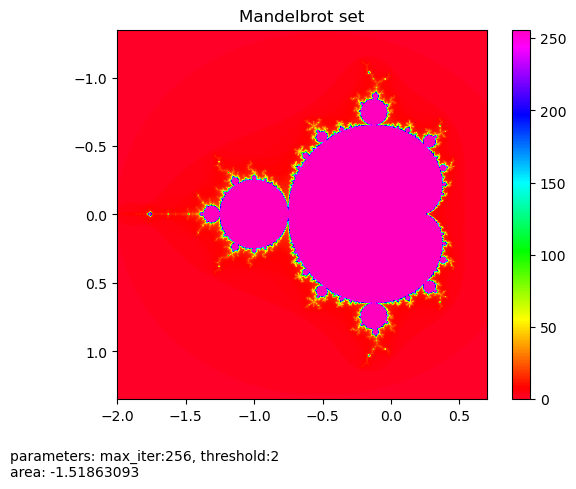

In [6]:
# xmin, xmax, ymin, ymax = -1.3, -1.05, -0.45, -0.2
# wsteps, hsteps = 1000, 1000


xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35,
wsteps, hsteps = 1000, 1000
max_iter = 256
threshold = 2


test_vectorized_mandelbrot = calculate_mandelbrot_vectorized(xmin,xmax,ymin,ymax,wsteps,hsteps,256, 2)
pt_area = (xmax - xmin) * (ymax - ymin) / (wsteps * hsteps)
area = np.sum(np.where(test_vectorized_mandelbrot == np.max(test_vectorized_mandelbrot), 1, 0)) * pt_area
plt.imshow(test_vectorized_mandelbrot, extent=(xmin, xmax, ymin, ymax), cmap='gist_rainbow')
plt.title("Mandelbrot set")
plt.figtext(0,-0.05,f'parameters: max_iter:{max_iter}, threshold:{threshold}\narea: {area}', horizontalalignment='left')
plt.colorbar()
plt.show()

## Approximating the Area

For a dense rectangular grid of points it is assumed that the area around the point can be calculated as:

$$
A_{pt}=\frac{1}{n_x n_y}A_R
$$

where $A_R$ is the area of the bounding region ($A_R=w\times h$) and $n_x$ and $n_y$ are the number of grid cells in $x$ and $y$ direction, respectively.

Then, to calculate the area $A_M$ of the Mandelbrot set we count the points which do not escape under the iteration function ($N_M$) and approximate the area as:

$$
A_M = N_M A_{pt}
$$

## Stochastic Sampling of the Mandelbrot set

The following function is a variation of the Mandelbrot iterator, this time iterating randomly sampled points instead of a regular grid.

In [7]:
# make simple mandelbrot function, this is needed for (current implementation) of LHS
def Mandelbrot(c, max_iter, threshold=2):
    '''Calculates the number of iterations until divergence for a given complex number c.
    Returns the number of iterations and the last value of z.'''
    z = 0
    for n in range(max_iter):
        if abs(z) > threshold:
            return n
        z = z**2 + c
    return max_iter

In [7]:
def calculate_mandelbrot_stochastic(xmin,xmax,ymin,ymax,n_samples,max_iter, threshold):
    '''Generates random point samples for the iteration function and passes it to the Mandelbrot function.
    Returns the initial point positions and the iterations until divergence above the threshold.'''
    c_samples = np.random.uniform((xmin, ymin), (xmax, ymax), (n_samples, 2))
    n3 = np.empty(n_samples)
    z_last = np.empty(n_samples, dtype=np.csingle)
    for i in range(n_samples):
        imaginary_component = 1j
        c = c_samples[i]
        n3[i], z_last[i] = Mandelbrot(c[0] + imaginary_component*c[1], max_iter, threshold)
    return (c_samples, n3, z_last)

The procedure below executes the stochastic Mandelbrot iteration and plots the following results:
- a scatterplot of the initial sampling of the space with a colour assigned to each sample depending on the number of iterations before their divergence;
- a scatterplot of the iterated positions of the samples, colours analogous to the above.

The purpose of the second plot is to observe the change in distribution of the samples after iteration, exploring the possibilities for resampling specific regions during the iteration process.

In [8]:
# xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
# n_samples = 20000

# # parameters
# max_iter = 512
# threshold = 2

# pts, iter, z_last = calculate_mandelbrot_stochastic(xmin,xmax,ymin,ymax,n_samples,max_iter,threshold=2)

# plt.scatter(pts.T[0], pts.T[1], c=iter, s=0.1)
# plt.xlim((xmin, xmax))
# plt.ylim((ymin, ymax))
# plt.title("Mandelbrot set: initial samples")
# plt.figtext(0,-0.05,f'parameters: max_iter:{max_iter}, threshold:{threshold}', horizontalalignment='left')
# plt.colorbar()
# plt.show()

# plt.scatter(z_last.real, z_last.imag, c=iter, s=0.1)
# plt.xlim((xmin, xmax))
# plt.ylim((ymin, ymax))
# plt.title("Mandelbrot set: iterated samples")
# plt.figtext(0,-0.05,f'parameters: max_iter:{max_iter}, threshold:{threshold}', horizontalalignment='left')
# plt.colorbar()
# plt.show()

In [9]:
def calculate_area_random_sampling_1(grid,xmin,xmax,ymin,ymax,wsteps,hsteps,threshold,iterations,sample_size,seed=None):
    # create a grid with given dimmensions.
    # r1 = np.linspace(xmin, xmax, wsteps)
    # r2_imaginary = np.linspace(ymin*1j, ymax*1j, hsteps)
    # real_array, complex_array = np.meshgrid(r1,r2_imaginary)
    # complex_coordinate_plane = real_array + complex_array
    complex_coordinate_plane = grid
    flattened_array = complex_coordinate_plane.flatten()
    # Implement random Sampling from the complex coordinate plane
    random_sample_indices = np.random.randint(0,len(flattened_array), size = sample_size)
    sampled_complex_coordinate_plane = flattened_array[random_sample_indices]
    # sampled_complex_coordinate_plane = np.array(random.sample(list(complex_coordinate_plane.flatten()),sample_size))
    output = vectorized_mandlebrot(sampled_complex_coordinate_plane, iterations, threshold)
    area = (np.sum(np.where(output == np.max(output), 1, 0)) / output.size ) * ((xmax - xmin) * (ymax - ymin))
    return area, output.shape

In [10]:
def calculate_area_random_sampling(grid, xmin, xmax, ymin, ymax, wsteps, hsteps, threshold, iterations, sample_size, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    index_x = np.random.randint(0, wsteps,size=sample_size)
    index_y = np.random.randint(0, hsteps,size=sample_size)
    points = grid[index_x, index_y]

    output = vectorized_mandlebrot(points, iterations, threshold)
    
    max_val = np.max(output)
    area_ratio = np.sum(output == max_val) / sample_size
    total_area = (xmax - xmin) * (ymax - ymin)
    
    return area_ratio * total_area, output.shape

In [11]:
# parameters
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
wsteps, hsteps = 10000, 10000


# grid creation
r1 = np.linspace(xmin, xmax, wsteps)
r2_imaginary = np.linspace(ymin*1j, ymax*1j, hsteps)
real_array, complex_array = np.meshgrid(r1,r2_imaginary)
complex_coordinate_plane = real_array + complex_array

grid = complex_coordinate_plane


In [13]:
calculate_area_random_sampling_1(grid,-2.0, 0.7, -1.35, 1.35, 10000, 10000, 2, 256, 10000000)


(1.5212633490000003, (10000000,))

In [14]:
def create_convergence_plot(grid, xmin, xmax, ymin, ymax, wsteps, hsteps, threshold, iteration_range, sample_range, num_runs, seed = None):
    area = np.zeros((len(iteration_range),len(sample_range),num_runs))
    for i, iteration in enumerate(iteration_range):
        for j, sample_size in enumerate(sample_range):
            for k in range(num_runs):
                area[i,j,k],_ = calculate_area_random_sampling(grid, xmin, xmax, ymin, ymax, wsteps, hsteps, threshold, iteration, sample_size, seed=None)
    return area

In [15]:
iteration_range = [64,128,256,512]
sample_range = [10**i for i in range(3, 7)]
num_runs = 3
area = create_convergence_plot(grid,-2.0, 0.7, -1.35, 1.35, 10000, 10000, 2, iteration_range, sample_range, num_runs, seed = None)
#area = create_convergence_plot(grid,-2.0, 0.7, -1.35, 1.35, 10000, 10000, 2, [256], [1000000],seed = None)

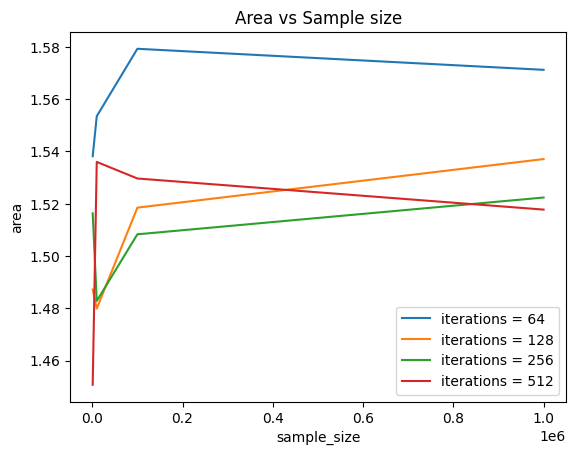

In [16]:
for i, iterations in enumerate(iteration_range):
    plt.plot(sample_range,area[i,:,2],label=f'iterations = {iterations}')
plt.legend()
plt.xlabel('sample_size')
plt.ylabel('area')
plt.title('Area vs Sample size')
plt.show()

## Latin Hypercube Sampling



In [10]:
def calculate_area_random_sampling_LHS(xmin, xmax, ymin, ymax, threshold, iterations, sample_size, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # creating a list of x and y coordinates from the xmin, xmax, ymin, ymax
    # note that stepsize = samplesize, so that the number of samples is equal to the number of steps. This is a requirement for LHS, see: https://en.wikipedia.org/wiki/Latin_hypercube_sampling
    x_coordinates = np.linspace(xmin, xmax, sample_size)[:-1]
    y_coordinates = np.linspace(ymin*1j, ymax*1j, sample_size)[:-1]

    # permutations of x and y are made to ensure that LHS requirements are met
    random.shuffle(x_coordinates)
    random.shuffle(y_coordinates)


    # creating a list of complex numbers from the x and y coordinates
    points = [(x_coordinates[i] + random.uniform(0, 1/sample_size)) + (y_coordinates[i] + random.uniform(0, 1/sample_size)*1j) for i in range(sample_size-1)]
    
    # calculating the area
    in_mandelbrot = 0
    for point in points:
        if Mandelbrot(point, iterations, threshold) == iterations:
            in_mandelbrot += 1


    # calculating the area
    area_ratio = in_mandelbrot / sample_size
    total_area = (xmax - xmin) * (ymax - ymin)
    
    return area_ratio * total_area

In [11]:
area_LHS_test = calculate_area_random_sampling_LHS(-2.0, 0.7, -1.35, 1.35, 2, 256, 1000000, seed=None)
area_LHS_test

1.5221665800000002

In [ ]:
def orthogonal_sampling(xmin, xmax, ymin, ymax, threshold, iterations, sample_size, seed=None):
    
    x_subrange = (xmax - xmin)/np.sqrt(sample_size)
    y_subrange = (ymax - ymin)/np.sqrt(sample_size)

    x_coordinates = np.linspace(xmin, xmax, np.sqrt(sample_size))[:-1]
    y_coordinates = np.linspace(ymin*1j, ymax*1j, np.sqrt(sample_size))[:-1]

    real_array, complex_array = np.meshgrid(x_coordinates,y_coordinates)
    complex_coordinate_plane = real_array + complex_array

    points = [real_array[i] + complex_array[i] for i in range(np.sqrt(sample_size))]

   calculate_area_random_sampling_LHS((xmin, xmax, ymin, ymax, threshold, iterations, sample_size, seed=None))


### Subgrid code commented out for now, don't think we will need it anymore but first need to do more test on calculate_area_random_sampling_LHS before we know for sure

In [ ]:
# def sample_subgrids(subgrid_list, sample_size):
#     samples = []
#     for subgrid in subgrid_list:
#         sample = random.sample(list(subgrid.flatten()), sample_size)
#         samples.append(sample)
#     return samples



In [ ]:
# def subdivide_grid(grid, sample_size, seed=None):
#     """devides the grid in n equal parts"""
#     subgrid_list = []
#     number_of_subgrids = int(grid.shape[0]/np.sqrt(sample_size))
#     subgrid_side_length = int(grid.shape[0]/number_of_subgrids)



#     for i in range(0, grid.shape[0], subgrid_side_length):
#         for j in range(0, grid.shape[0], subgrid_side_length):
#             subgrid = grid[i:i+subgrid_side_length, j:j+subgrid_side_length]
#             subgrid_list.append(subgrid)
#     return subgrid_list

           

    
    

In [ ]:
# # make a 4 by 4 matrix with increasing numbers
# a = np.arange(1,17).reshape(4,4)
# print(a)

In [ ]:
# list_of_subgrids = subdivide_grid(a, 4)

## Simulation Framework

The framework constructed below consists of the following modules:

[Sample Generator] -> [Complex Converter] -> [Mandelbrot Iterator] -> [Area Estimator] -> [Statistics Plotting Function]

An additional procedure plots an instance of the sampling distribution tothether with the results of the Mandelbrot iteration.

### Mandelbrot Iterator

In [17]:
def mandelbrot(c, max_iter, threshold=2):
    '''Calculates the number of iterations until divergence for a given complex number c.
    Returns the number of iterations until divergence beyond threshold.'''
    z = 0
    for n in range(max_iter):
        if abs(z) > threshold:
            return n
        z = z**2 + c
    return max_iter

In [18]:
def vectorized_mandelbrot(samples_complex, max_iter, threshold=2):
    '''Calculates the number of iterations until divergence for a numpy array of complex numbers.
    Returns the number of iterations until divergence beyond threshold.'''
    z = samples_complex.copy()
    diverged_at = np.full(z.shape, max_iter)

    for n in range(max_iter):
        diverged = abs(z) > threshold
        diverged_at[diverged & (diverged_at == max_iter)] = n
        z[~diverged] = z[~diverged]**2 + samples_complex[~diverged]

    return diverged_at

### Utility Functions

In [19]:
def coords_to_complex(coords_array):
    '''Takes an input array of shape (2, sample_size) containing
    the x coordinates in the first row and the y coordinates in the second.
    Converts this array to complex numbers.
    '''
    return coords_array[0] + coords_array[1]*1j

In [20]:
def get_median_divisor(number):
    '''Returns the median of all the divisors for a number.
    '''
    divisors = np.array([x for x in range(1, int(number) + 1) if number % x == 0])

    return divisors[int(0.5*len(divisors))]

### Sampling Methods

In [4]:
def grid_sampling(xmin, xmax, ymin, ymax, sample_size):
    '''Performs deterministic regular grid sampling
    '''
    samples_x = np.linspace(xmin, xmax, int(np.sqrt(sample_size)))
    samples_y = np.linspace(ymin, ymax, int(np.sqrt(sample_size)))
    samples_x_grid, samples_y_grid = np.meshgrid(samples_x, samples_y)

    return np.vstack((samples_x_grid.reshape((1, sample_size)), samples_y_grid.reshape((1, sample_size))))

In [70]:
def fibonacci_sampling(xmin, xmax, ymin, ymax, sample_size):
    constants.golden

    radius = np.sqrt(max(abs(xmin), abs(xmax))**2 + max(abs(ymin), abs(ymax))**2)/np.sqrt(sample_size)
    ts = np.arange(0, sample_size, 1)
    samples_x = radius*np.sqrt(ts)*np.cos(ts*2*np.pi/constants.golden)
    samples_y = radius*np.sqrt(ts)*np.sin(ts*2*np.pi/constants.golden)

    sample_pts = np.vstack((samples_x, samples_y)).T

    sample_pts_culled = [sp for sp in sample_pts if xmin < sp[0] < xmax and ymin < sp[1] < ymax]

    sample_pts_culled = np.array(sample_pts_culled).T
    
    return sample_pts_culled

In [6]:
def pure_random_sampling(xmin, xmax, ymin, ymax, sample_size, seed=None):
    '''Performs pure uniform random sampling over the given interval.
    '''
    if seed is not None:
        np.random.seed(seed)
    
    return np.random.uniform((xmin, ymin), (xmax, ymax), size=(sample_size, 2)).T

In [7]:
def latin_hypercube_sampling(xmin, xmax, ymin, ymax, sample_size, seed=None):
    '''Performs latin hypercube sampling over the given interval.
    '''

    if seed is not None:
        np.random.seed(seed)

    # creating a list of x and y coordinates from the xmin, xmax, ymin, ymax
    # note that stepsize = samplesize, so that the number of samples is equal to the number of steps. This is a requirement for LHS, see: https://en.wikipedia.org/wiki/Latin_hypercube_sampling
    x_base = np.linspace(xmin, xmax, sample_size + 1)[:-1]
    y_base = np.linspace(ymin, ymax, sample_size + 1)[:-1]

    # permutations of x and y are made to ensure that LHS requirements are met
    random.shuffle(x_base)
    random.shuffle(y_base)

    # adding a random value to the base grid
    x_coords = x_base + np.random.uniform(0, (xmax - xmin)/sample_size, size=x_base.shape)
    y_coords = y_base + np.random.uniform(0, (ymax - ymin)/sample_size, size=x_base.shape)
    
    return np.vstack([x_coords, y_coords])

In [8]:
def orthogonal_sampling(xmin, xmax, ymin, ymax, sample_size, n_sub_intervals, seed=None):
    '''Performs orthogonal sampling over the given interval.
    n_sub_intervals indicates the number of subdivisions per dimension inside a cell of the supergrid.
    '''

    n_intervals = int(np.sqrt(sample_size))
    
    # Guarantee that interval is a power of two and is divisible by number of subintervals
    if n_intervals%n_sub_intervals != 0:
        print("Mismatched grid parameters!")
        return None

    n_intervals = int(n_intervals)

    if seed is not None:
        np.random.seed(seed)
    
    # base coordinates for large grid cells
    x_base = np.linspace(xmin, xmax, n_intervals + 1)[:-1]
    y_base = np.linspace(ymin, ymax, n_intervals + 1)[:-1]

    x_grid_base, y_grid_base = np.meshgrid(x_base, y_base)

    x_grid_base = x_grid_base.flatten()
    y_grid_base = y_grid_base.flatten()

    # base coordinates for fine grid cells
    x_interval = (xmax - xmin) / n_intervals
    y_interval = (ymax - ymin) / n_intervals
    x_base_sub = np.linspace(0, x_interval, n_sub_intervals+1)[:-1]
    y_base_sub = np.linspace(0, y_interval, n_sub_intervals+1)[:-1]

    # permutations of x and y are made to ensure that LHS requirements are met
    x_base_sub_permutations = np.array([np.random.permutation(x_base_sub) for _ in range(n_intervals**2//n_sub_intervals)])
    y_base_sub_permutations = np.array([np.random.permutation(y_base_sub) for _ in range(n_intervals**2//n_sub_intervals)])
    x_base_sub_permutations = x_base_sub_permutations.flatten()
    y_base_sub_permutations = y_base_sub_permutations.flatten()

    # adding large grid coordinates + permuted fine grid coordinates + random component
    x_coords = x_grid_base + x_base_sub_permutations + np.random.uniform(0, x_interval/n_sub_intervals, size=x_grid_base.shape)
    y_coords = y_grid_base + y_base_sub_permutations + np.random.uniform(0, y_interval/n_sub_intervals, size=y_grid_base.shape)

    return np.vstack([x_coords, y_coords])

### Plotting Method

In [9]:
def plot_samples_mandelbrot(xmin, xmax, ymin, ymax, samples, iter_vals, **params):
    '''Plots the sampling distribution, indicating the relationship to the Mandelbrot set.
    The input **params takes the parameters used for the simulation
    '''

    # plot grid for stratified methods
    if params['sampling_method'] == 'LHS' and samples.shape[0] <= 100:
        plt.xticks(np.linspace(xmin, xmax, samples.shape[0]+1), minor=True)
        plt.yticks(np.linspace(ymin, ymax, samples.shape[0]+1), minor=True)
        plt.grid(which='minor')
    if params['sampling_method'] == 'Orthogonal Sampling' and samples.shape[0] <= 100:
        plt.xticks(np.linspace(xmin, xmax, samples.shape[0]//params['sub_lvl'] + 1), minor=False)
        plt.yticks(np.linspace(ymin, ymax, samples.shape[0]//params['sub_lvl'] + 1), minor=False)
        plt.xticks(np.linspace(xmin, xmax, samples.shape[0]+1), minor=True)
        plt.yticks(np.linspace(ymin, ymax, samples.shape[0]+1), minor=True)
        plt.grid(which='both')
    
    plt.scatter(samples.real, samples.imag, c=iter_vals, s=1000/samples.shape[0])
    plt.xlim((xmin, xmax))
    plt.ylim((ymin, ymax))
    plt.title(f"Mandelbrot set: {params['sampling_method']}")
    plt.figtext(0,-0.05,f"Parameters: max_iter: {params['max_iter']}, threshold: {params['threshold']}\narea: {params['area']}", horizontalalignment='left')
    plt.colorbar(label='escape iterations')

    plt.show()

### Area Estimation

In [10]:
def calc_area(xmin, xmax, ymin, ymax, iter_vals):
    '''Estimates the area of the Mandelbrot set by counting
    the sample points which did not escape during the iteration
    and computing their fraction from the entire sample number.
    '''
    
    sample_size = iter_vals.shape[0]
    in_mandelbrot = np.sum(np.where(iter_vals == np.max(iter_vals), 1, 0))

    area_ratio = in_mandelbrot / sample_size
    total_area = (xmax - xmin) * (ymax - ymin)

    return area_ratio * total_area

### Statistics Calculation

In [11]:
def parameter_exploration(xmin, xmax, ymin, ymax, sample_range, iter_range, num_runs, sampling_type, seed_range=None):
    '''Performs multiple simulations with different parameter combinations provided
    by the arrays sample_range and iter_range. If seed_range is not provided,
    consecutive seeds starting from zero are taken.
    Outputs a DataFrame containing the area estimation results.
    '''

    sim_table = np.empty((len(iter_range)*len(sample_range)*num_runs, 4))
    seed_ct = 0
    for i, iteration in enumerate(iter_range):
        for j, sample_size in enumerate(sample_range):
            for k in range(num_runs):
                if seed_range:
                    seed = seed_range[seed_ct]
                else:
                    seed = seed_ct
                
                # Determine sampling function
                match sampling_type:
                    case 'random': pt_samples = pure_random_sampling(xmin, xmax, ymin, ymax, sample_size, seed=seed)
                    case 'LHS': pt_samples = latin_hypercube_sampling(xmin, xmax, ymin, ymax, sample_size, seed=seed)
                    case 'ortho': pt_samples = orthogonal_sampling(xmin, xmax, ymin, ymax, sample_size, n_sub_intervals=get_median_divisor(np.sqrt(sample_size)), seed=seed)
                    case _: print("Invalid sampling function")
                
                complex_samples = coords_to_complex(pt_samples)
                mandelbrot_iters = vectorized_mandelbrot(complex_samples, iteration)
                area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters)

                index = (i*len(sample_range) + j)*num_runs + k
                sim_table[index] = np.array([k, iteration, sample_size, area])

                seed_ct += 1
    
    df_simulations = pd.DataFrame(sim_table, columns=['Simulation', 'Iterations', 'Samples', 'Area'])

    return df_simulations

## Run Functions

A quasi-ground-truth value for the area estimation can be obtained by the brute-force approach of sampling a dense uniform grid that sets a maximum boundary for the number of samples used in the subsequent stochastic experiments.

(2, 1000000)


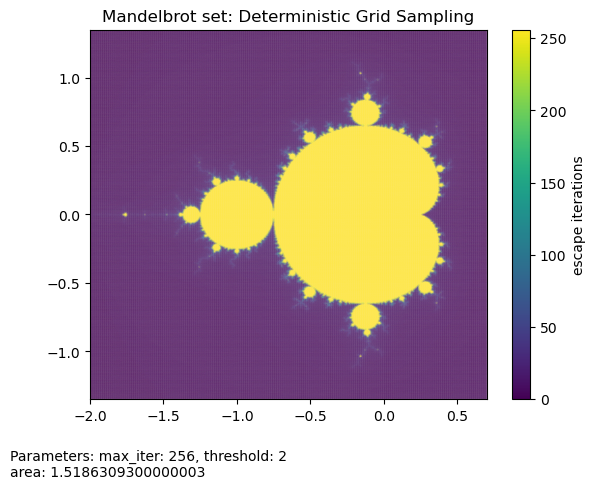

In [28]:
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
sample_size = 1000000 # run with 100000000 when at home
max_iter = 256

# brute-force deterministic grid sampling
pt_samples = grid_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters,
                        sampling_method='Deterministic Grid Sampling', max_iter=max_iter, threshold=2, area=area)

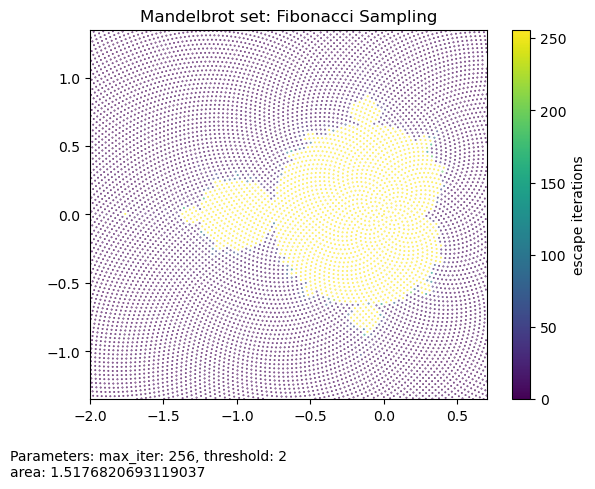

In [77]:
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
sample_size = 20000
max_iter = 256

# deterministic fibonacci spiral sampling
pt_samples = fibonacci_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters,
                        sampling_method='Fibonacci Sampling', max_iter=max_iter, threshold=2, area=area)

The following procedure tests the three sampling types using a single simulation per type.

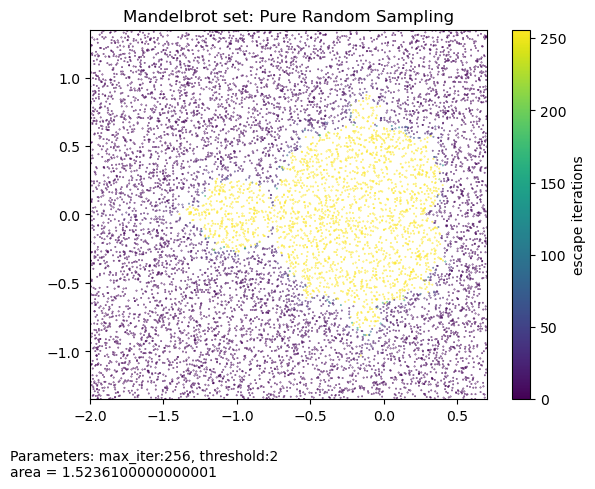

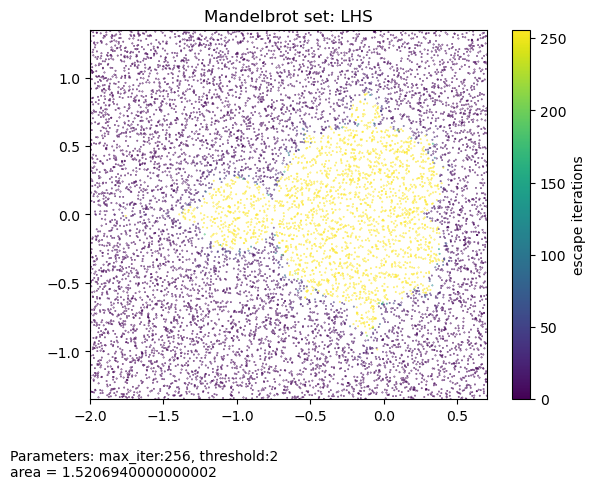

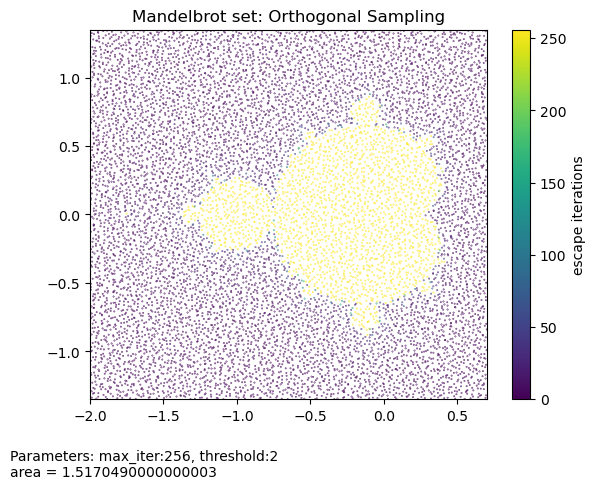

In [266]:
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
sample_size = 10000
max_iter = 256

# test pure random sampling
pt_samples = pure_random_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters,
                        sampling_method='Pure Random Sampling', max_iter=max_iter, threshold=2, area=area)

# test LHS
pt_samples = latin_hypercube_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters,
                        sampling_method='LHS', max_iter=max_iter, threshold=2, area=area)

# test orthogonal sampling
pt_samples = orthogonal_sampling(xmin, xmax, ymin, ymax, sample_size, 10)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters,
                        sampling_method='Orthogonal Sampling', max_iter=max_iter, threshold=2, sub_lvl=10, area=area)

The next procedure runs multiple simulations for different parameter combinations and plots the statistics for all different sampling strategies.

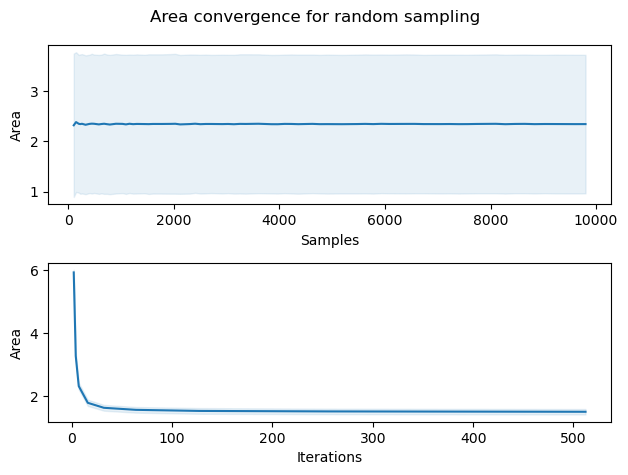

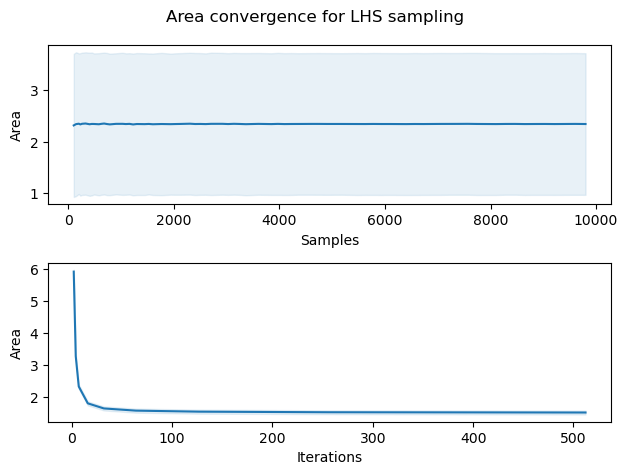

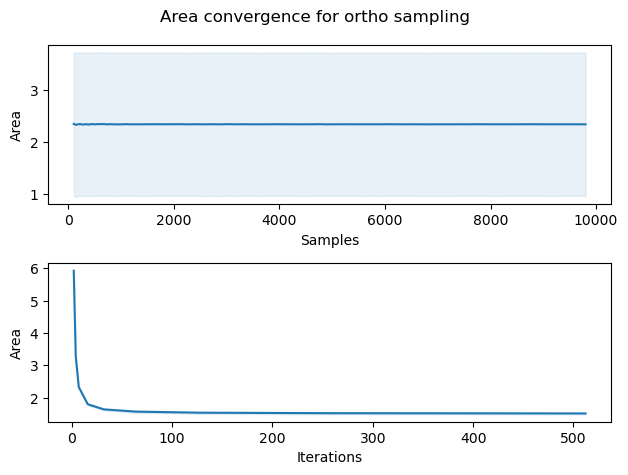

In [19]:
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
sample_range = np.array([x for x in np.arange(10, 100, 1, dtype=int) if get_median_divisor(x) not in (1, x)])**2 # avoid prime numbers
iter_range = np.geomspace(2, 512, 9, dtype=int)
num_runs = 30

sampling_types = ['random', 'LHS', 'ortho']

for sampling_type in sampling_types:
    df_area = parameter_exploration(xmin, xmax, ymin, ymax, sample_range, iter_range, num_runs, sampling_type=sampling_type)
    fig, axs = plt.subplots(2, 1)
    fig.suptitle(f"Area convergence for {sampling_type} sampling")
    sns.lineplot(df_area, x='Samples', y='Area', errorbar='sd', ax=axs[0], err_kws={'alpha':0.1})
    sns.lineplot(df_area, x='Iterations', y='Area', errorbar='sd', ax=axs[1], err_kws={'alpha':0.1})
    # ax.set_yscale('symlog')
    # ax.legend(title='Iterations', ncols=3)
    plt.tight_layout()
    plt.show()
    

To get an informative picture of the distribution of each sampling methods, the results are plotted in a series of histograms, using the parameters yielding the highest precision in the previous experiment (10000 samples and 512 iterations).

Area sample mean (random sampling): 1.511497665
Area sample variance (random sampling): 0.0010634410946259046
Area sample standard deviation (random sampling): 0.032610444563450906
Area sample mean (LHS sampling): 1.5120152550000001
Area sample variance (LHS sampling): 0.000401959526361784
Area sample standard deviation (LHS sampling): 0.020048928309557696
Area sample mean (ortho sampling): 1.5138887850000002
Area sample variance (ortho sampling): 3.1247008290226166e-05
Area sample standard deviation (ortho sampling): 0.005589902350687905


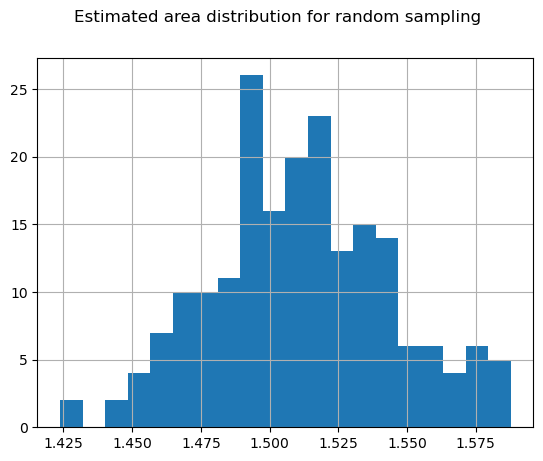

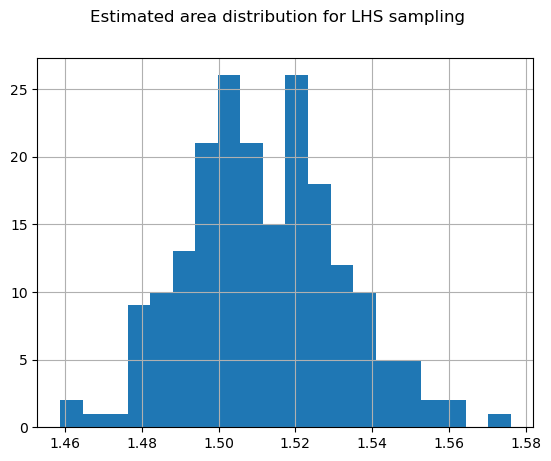

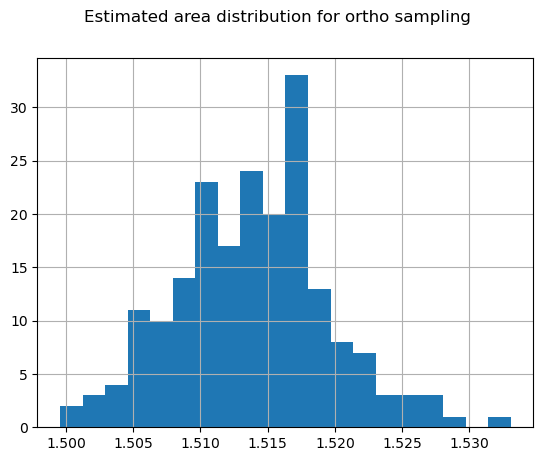

In [18]:
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
sample_range = np.array([10000])
iter_range = np.array([512])
num_runs = 200

sampling_types = ['random', 'LHS', 'ortho']

for sampling_type in sampling_types:
    df_area = parameter_exploration(xmin, xmax, ymin, ymax, sample_range, iter_range, num_runs, sampling_type=sampling_type)
    fig, ax = plt.subplots()
    fig.suptitle(f"Estimated area distribution for {sampling_type} sampling")
    sample_mean = df_area['Area'].mean()
    sample_var = df_area['Area'].var()
    sample_std = df_area['Area'].std()
    print(f"Area sample mean ({sampling_type} sampling): {sample_mean}")
    print(f"Area sample variance ({sampling_type} sampling): {sample_var}")
    print(f"Area sample standard deviation ({sampling_type} sampling): {sample_std}")
    df_area['Area'].hist(bins=num_runs//10, ax=ax)

## Statistical testing

Statistical testing of the simulation will allow to to quantify out confidence in how much different method differ.

This consists of two phases:

Comparing each method (Classic Monte Carlo, LHS, Orthogonal, Improved stochastic (yet to be devised)) against our estimated ground truth, $A_{m*}$

To do so we perform a one sample T-test between the area of $A_{m*}$, which we call $\mu_{0}$ and the expected value of the area obtained from each of our methods $\hat{X}$.
Our obtained value of the area from $A_{m*}$, $X_{0}$ does not vary accross runs (it only depends on the coarseness of the grid and not on the spread of the samples). 
However, the estimate of the area using one of our sampling methods $\hat{X}$ does vary, meaning we need to take into account our sample standard deviation $S_{\bar{x}}$. This makes a one sample t-test the approriate choice. This results in the following test statistic:

$T=\frac{X-\mu_0}{s_{\bar{x}}}$

We check to see if the T-statistic is outside a critcal region of our choosing (for example, for a two sided test |T. Actual| > 1.96 for $\alpha = 0.05$).
We also need to test if the distribution obtained from our simulations conform to the assumptions of the T-Test (i.i.d. random sample, etc.).


We first perform 4 pairwise tests:

$\hat{X}_{Classic Monte Carlo}$ vs. $\mu_{0}$

$\hat{X}_{LHS}$ vs. $\mu_{0}$

$\hat{X}_{Orthogonal Sampling}$ vs. $\mu_{0}$

$\hat{X}_{Improved Stochastic Method}$ vs. $\mu_{0}$


As soon as we have a statistical estimate of the difference between the area estimated by out methods, we test the difference between methods using a two sample test Welch test (as the sample variances are known but the population variances are not. For this we use the following test statistic:


$T_{Welch} = \frac{\bar{X}-\bar{Y}}{\sqrt{\frac{S_x^2}{n_x}+\frac{S_y^2}{n_y}}}$


$\hat{X}_{Classic Monte Carlo}$ vs. $\hat{X}_{LHS}$

$\hat{X}_{Classic Monte Carlo}$ vs. $\hat{X}_{Orthogonal Sampling}$

$\hat{X}_{Classic Monte Carlo}$ vs. $\hat{X}_{Improved Stochastic Method}$

$\hat{X}_{LHS}$ vs. $\hat{X}_{Orthogonal Sampling}$

$\hat{X}_{LHS}$ vs. $\hat{X}_{Improved Stochastic Method}$

$\hat{X}_{Orthogonal Sampling}$ vs. $\hat{X}_{Improved Stochastic Method}$







In [1]:


# t-test:https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html
# one sample t_test

scipy.stats.ttest_1samp(a, popmean, axis=0, nan_policy='propagate', alternative='two-sided', *, keepdims=False)


# welch's t-test: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
# two sample t_test, put equal variances at False
scipy.stats.ttest_ind(a, b, axis=0, equal_var=False, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=0, *, keepdims=False)

SyntaxError: incomplete input (2506481983.py, line 7)